# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 07**: Structured Streaming with Files 

**Date**: October 10th 2025

**Student Name**: Luis Adrian Bravo Ramirez

**Professor**: Pablo Camarillo Ramirez

# Creating log generator script
This log generator script will create a CSV file that contains:
- Datetime
- Log level (INFO, WARN or ERROR)
- Log Description
- Server
You have to create an object using LogGenerator class and send the output you'll want to write and the quantity of random logs that the file will have. 

In [1]:
!pwd
!ls -l /opt/spark/work-dir/data/lab07_luis_bravo_logs/

/opt/spark/work-dir
total 4
-rw-r--r-- 1 root root 3090 Oct  8 00:53 logs_generator.py


In [2]:
from luisbravor00.logs_generator import LogGenerator

log_generator = LogGenerator("/opt/spark/work-dir/data/lab07_luis_bravo_logs/error_log.csv", 10)
log_generator.generate_logs()

Writing 10 logs...
Succesfully wrote logs to /opt/spark/work-dir/data/lab07_luis_bravo_logs/error_log.csv csv file!


In [3]:
# EXAMPLE FOR ERROR LOG CSV FILE
!ls -l /opt/spark/work-dir/data/lab07_luis_bravo_logs/error_log*
!cat /opt/spark/work-dir/data/lab07_luis_bravo_logs/error_log*

-rw-r--r-- 1 root root 678 Oct  8 00:54 /opt/spark/work-dir/data/lab07_luis_bravo_logs/error_log.csv
 2025-10-08 01:25:19 | WARN | Disk usage 95% | server-node-3 
 2025-10-08 01:44:10 | INFO | Health check passed | server-node-2 
 2025-10-08 01:12:30 | WARN | Low available storage | server-node-4 
 2025-10-08 01:51:53 | INFO | Health check passed | server-node-3 
 2025-10-08 01:12:13 | ERROR | 500 Internal Server Error | server-node-1 
 2025-10-08 01:37:38 | WARN | Disk usage 95% | server-node-2 
 2025-10-08 01:37:54 | INFO | Configuration loaded | server-node-4 
 2025-10-08 01:02:50 | INFO | Configuration loaded | server-node-3 
 2025-10-08 01:25:30 | INFO | Configuration loaded | server-node-4 
 2025-10-08 01:38:24 | ERROR | File not found | server-node-2 


# Structured Streaming with Files 

### Create SparkSession

In [4]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (files)") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/08 00:55:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Create a data stream for files

In [5]:
# RUN THIS FIRST, THEN RUN THE LOG GENERATOR SCRIPT FROM A TERMINAL ON JUPYTER FROM YOUR WEB BROWSER
from pyspark.sql.functions import col, trim
from luisbravor00.spark_utils import SparkUtils

logs_schema = SparkUtils.generate_schema([
    ("timestamp", "string"),
    ("level", "string"),
    ("description", "string"),
    ("server", "string")
])

logs_df = spark.readStream \
            .format("csv") \
            .option("sep", "|") \
            .schema(logs_schema) \
            .load("/opt/spark/work-dir/data/lab07_luis_bravo_logs/")

error_logs_df = logs_df.filter(trim(col("level")) == "ERROR")

query = error_logs_df.writeStream \
             .outputMode("append") \
             .format("console") \
             .start()

query.awaitTermination(60) # Wait 60 seconds before closing the stream

-------------------------------------------
Batch: 0
-------------------------------------------
+--------------------+-------+--------------------+---------------+
|           timestamp|  level|         description|         server|
+--------------------+-------+--------------------+---------------+
| 2025-10-08 01:12...| ERROR | 500 Internal Ser...| server-node-1 |
| 2025-10-08 01:38...| ERROR |     File not found | server-node-2 |
+--------------------+-------+--------------------+---------------+

-------------------------------------------
Batch: 1
-------------------------------------------
+--------------------+-------+--------------------+---------------+
|           timestamp|  level|         description|         server|
+--------------------+-------+--------------------+---------------+
| 2025-10-08 01:06...| ERROR | Timeout while pr...| server-node-1 |
| 2025-10-08 01:08...| ERROR |  Permission denied | server-node-3 |
| 2025-10-08 01:27...| ERROR | Timeout while pr...| serve

False

### Logs Creation (from console with JupyterNotebook)
I added my logs generator py file to the /opt/spark/work-dir/data/lab07_luis_bravo_logs/ folder so I could create my log files without any problem. 

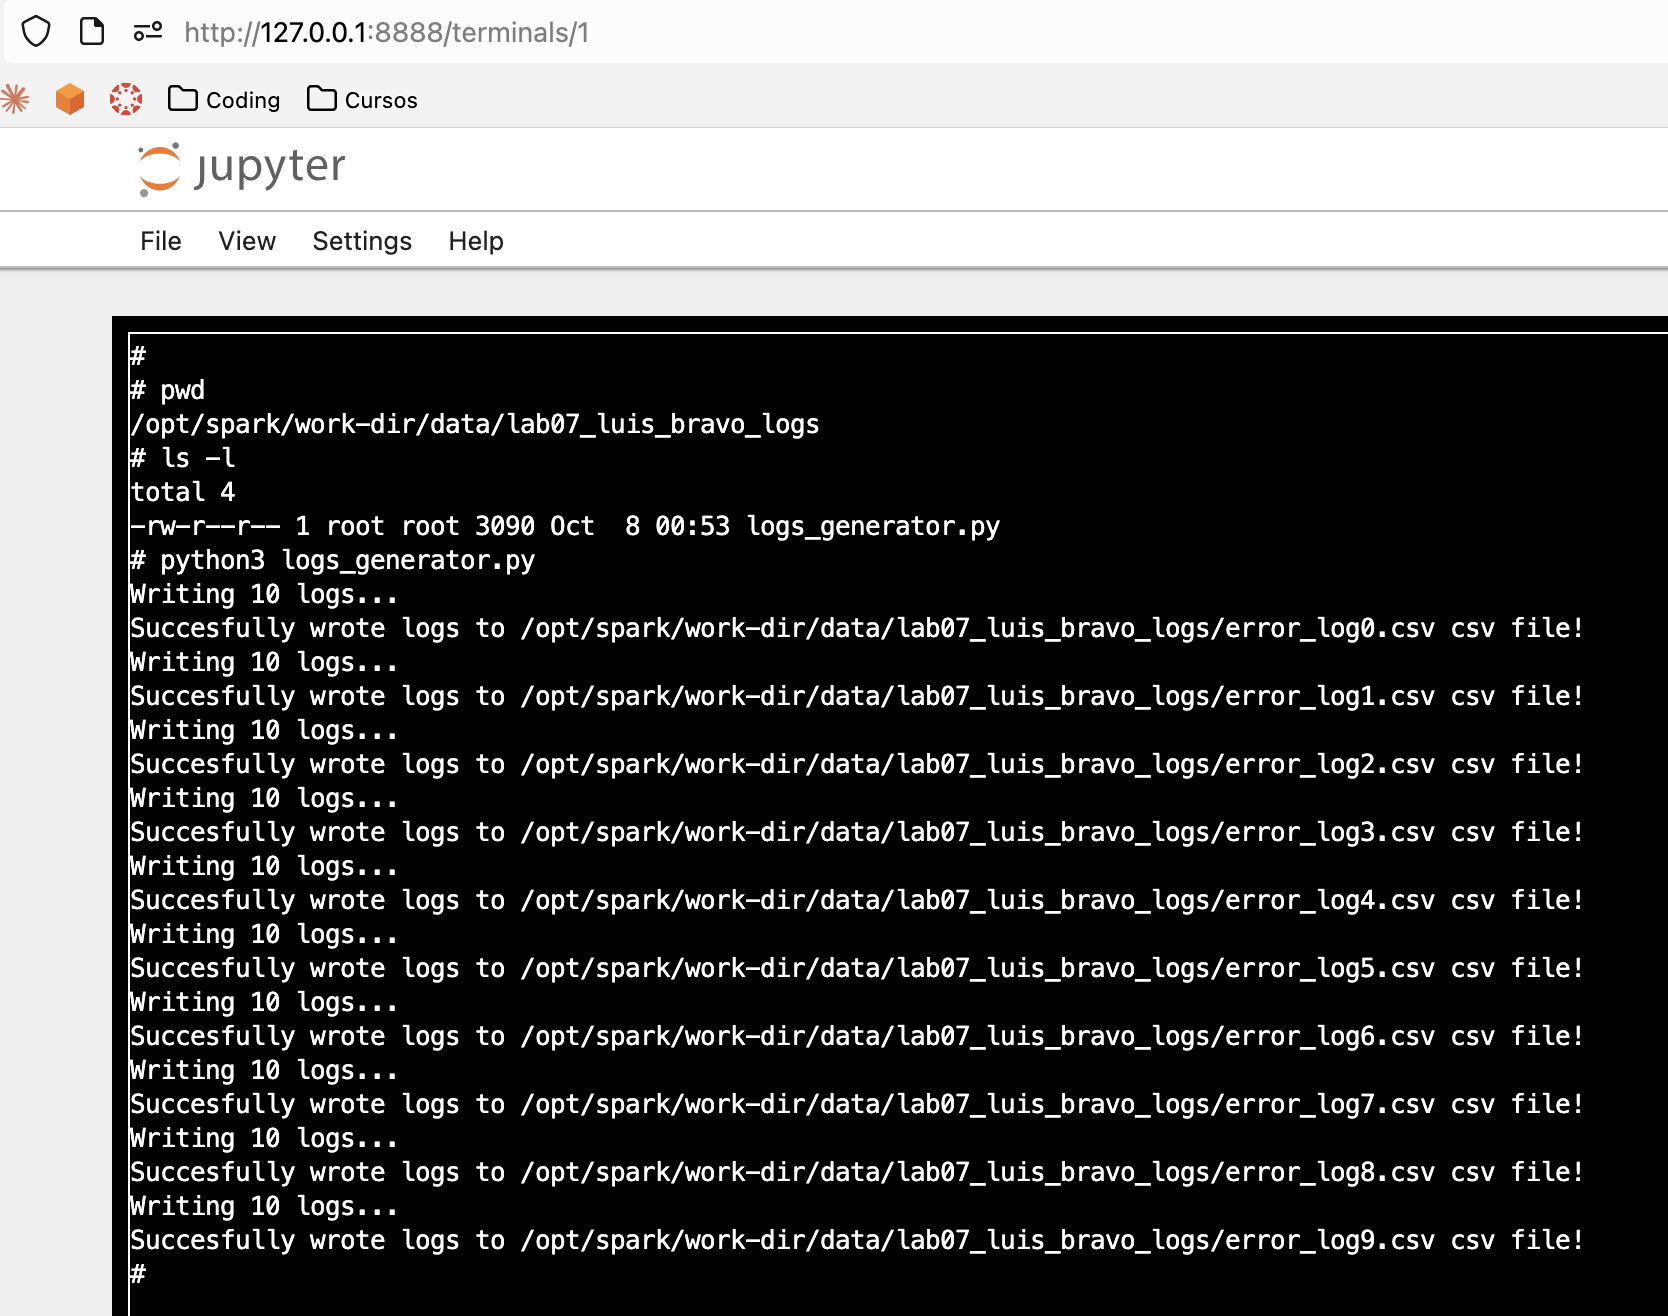

And this is how the batches look, filtering only the ERROR level logs.

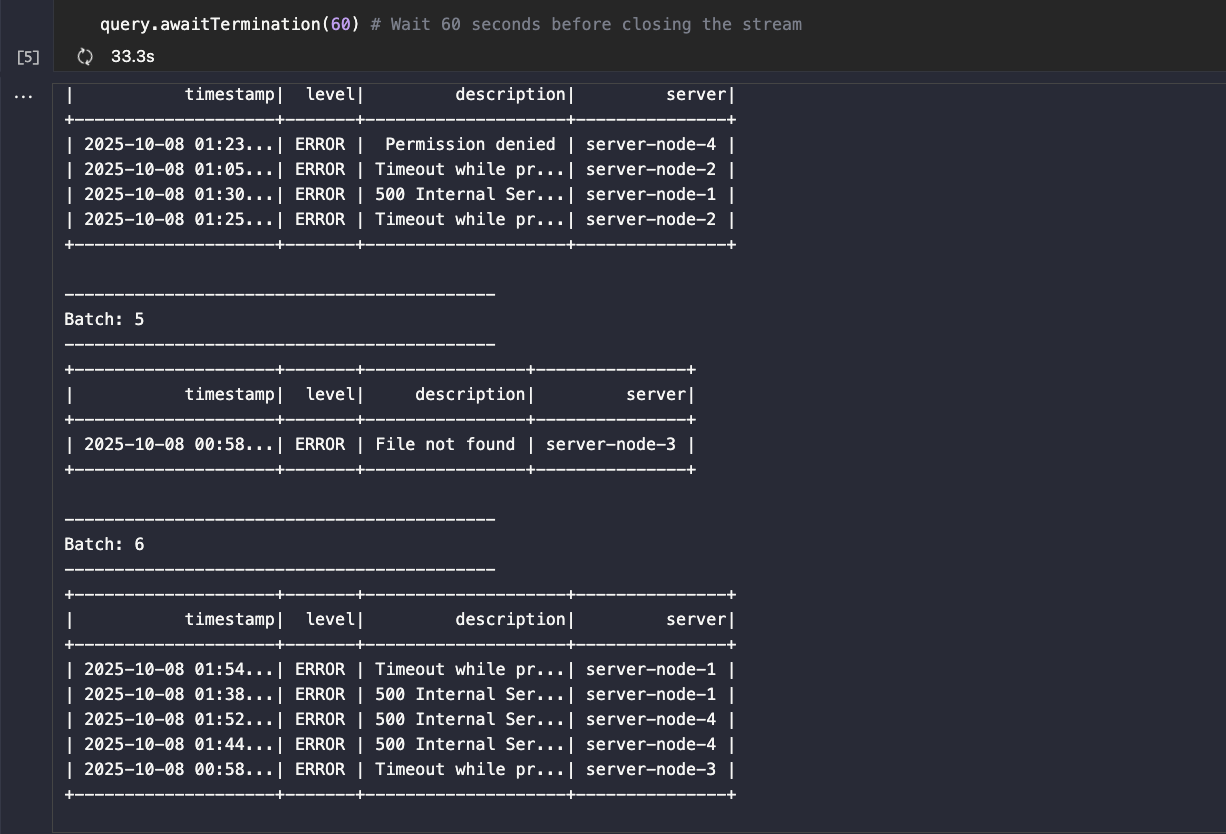

Checking the last batch, we can see that we have two ERROR level logs. Let's verify that.

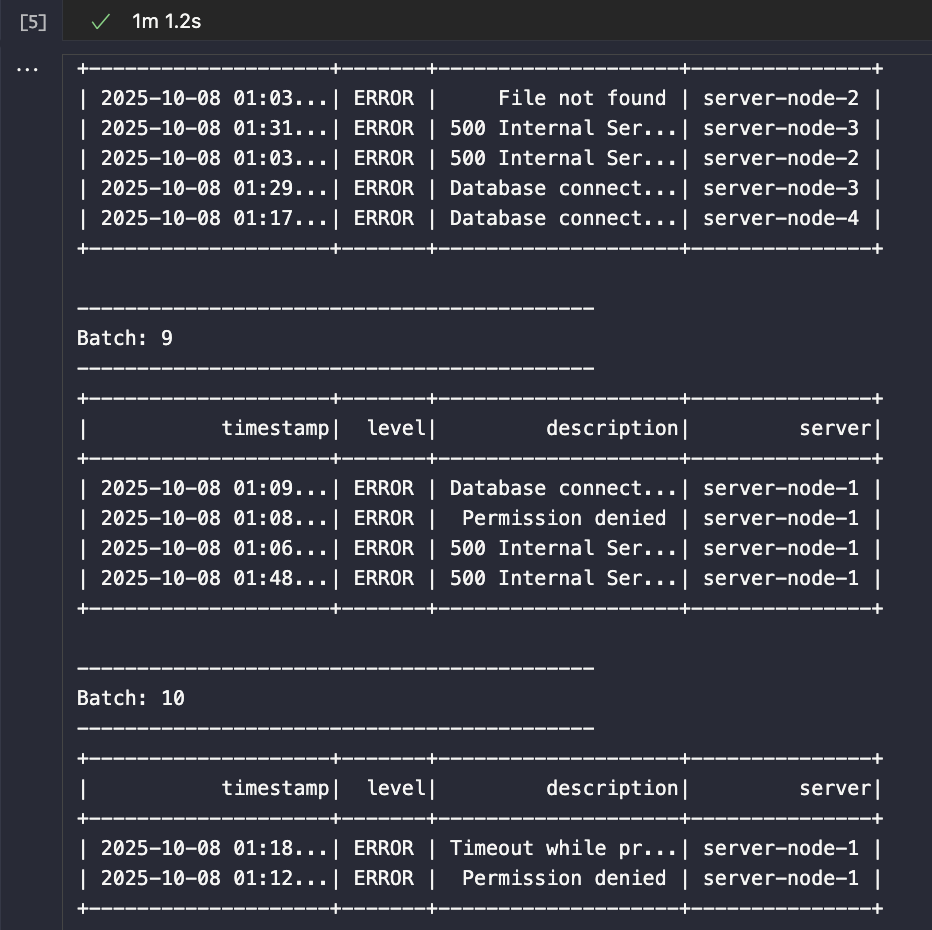

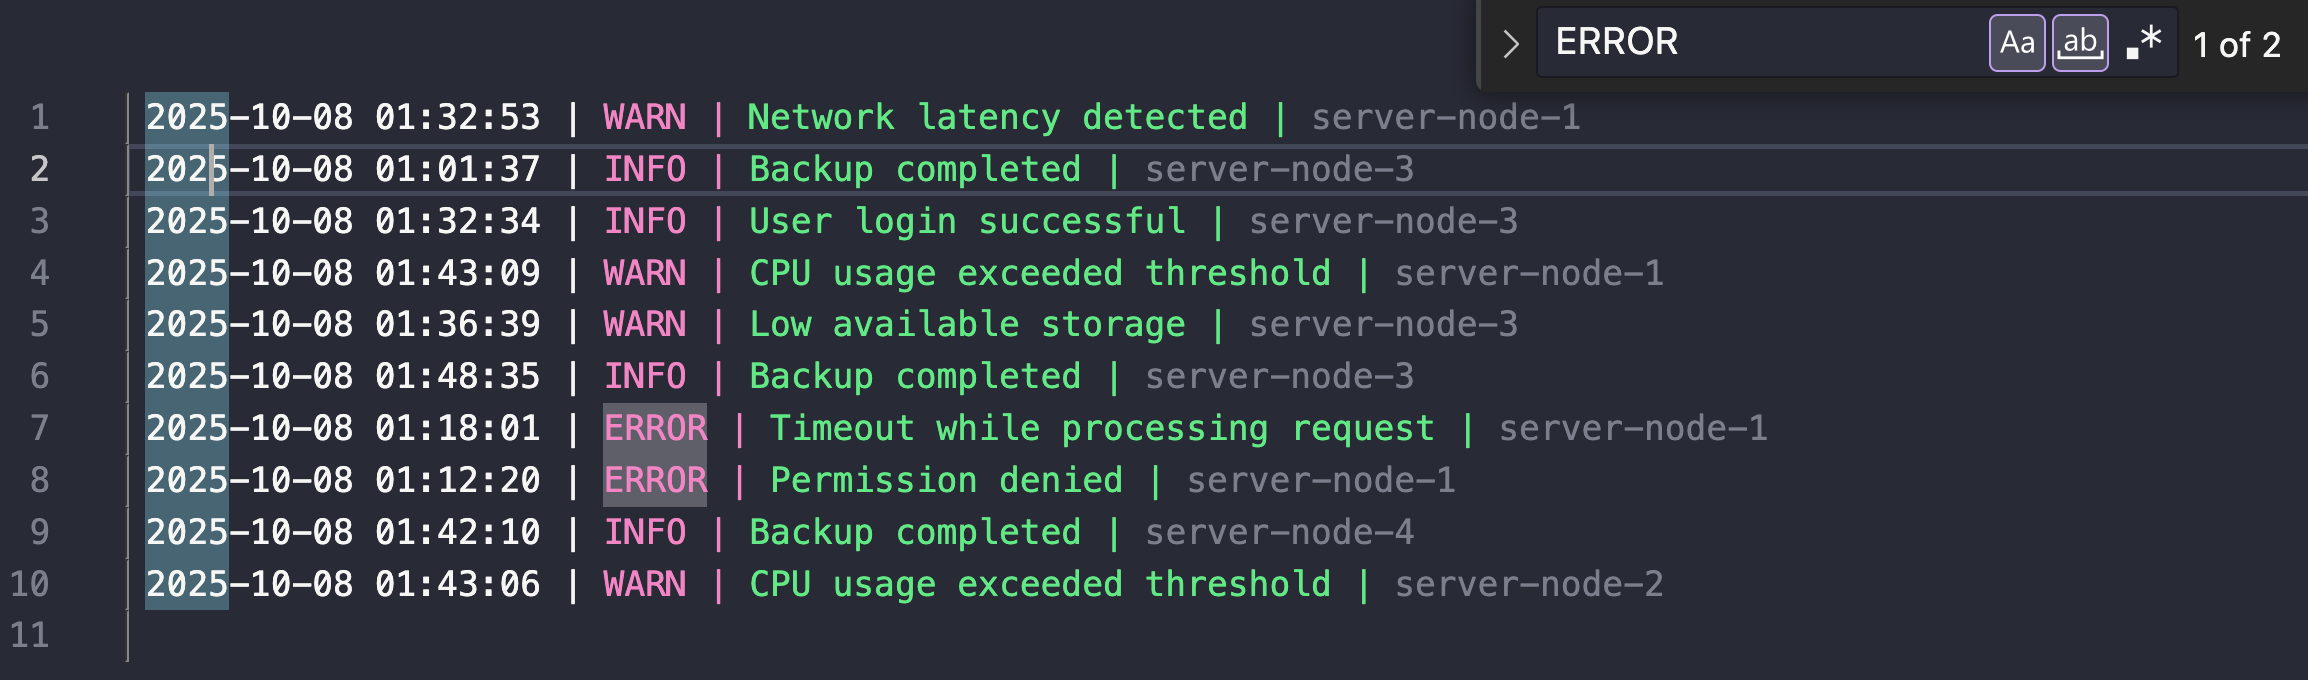